This notebook does the same thing that Synthetic_Mars_Wind_Profile.ipynb but for several files in row.

In [99]:
# %matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from local_utils import *
import matplotlib.dates as md

kappa = 0.4

path = '/Users/brian/Documents/research/Active Projects/Measuring_Wind_with_Ingenuity/code/MEDA_WS_Data/'
file_list_name = path + "xml_list.txt"
file_list = np.genfromtxt(file_list_name, dtype=str)

time, wind = retrieve_time_wind(path + file_list[1])
correct_zstar = 3. # cm
correct_ustar = kappa*np.mean(wind)/np.log(zs[0]/correct_zstar)
print(correct_ustar)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Processing label: /Users/brian/Documents/research/Active Projects/Measuring_Wind_with_Ingenuity/code/MEDA_WS_Data/WE__0091___________DER_WS__________________P02.xml
Now processing a Header structure: HEADER
Now processing a Table_Delimited structure: TABLE
0.3147787942269009


Processing label: /Users/brian/Documents/research/Active Projects/Measuring_Wind_with_Ingenuity/code/MEDA_WS_Data/WE__0076___________DER_WS__________________P02.xml
Now processing a Header structure: HEADER
Now processing a Table_Delimited structure: TABLE
Processing label: /Users/brian/Documents/research/Active Projects/Measuring_Wind_with_Ingenuity/code/MEDA_WS_Data/WE__0091___________DER_WS__________________P02.xml
Now processing a Header structure: HEADER
Now processing a Table_Delimited structure: TABLE
Processing label: /Users/brian/Documents/research/Active Projects/Measuring_Wind_with_Ingenuity/code/MEDA_WS_Data/WE__0107___________DER_WS__________________P02.xml
Now processing a Header structure: HEADER
Now processing a Table_Delimited structure: TABLE
Processing label: /Users/brian/Documents/research/Active Projects/Measuring_Wind_with_Ingenuity/code/MEDA_WS_Data/WE__0133___________DER_WS__________________P02.xml
Now processing a Header structure: HEADER
Now processing a Table

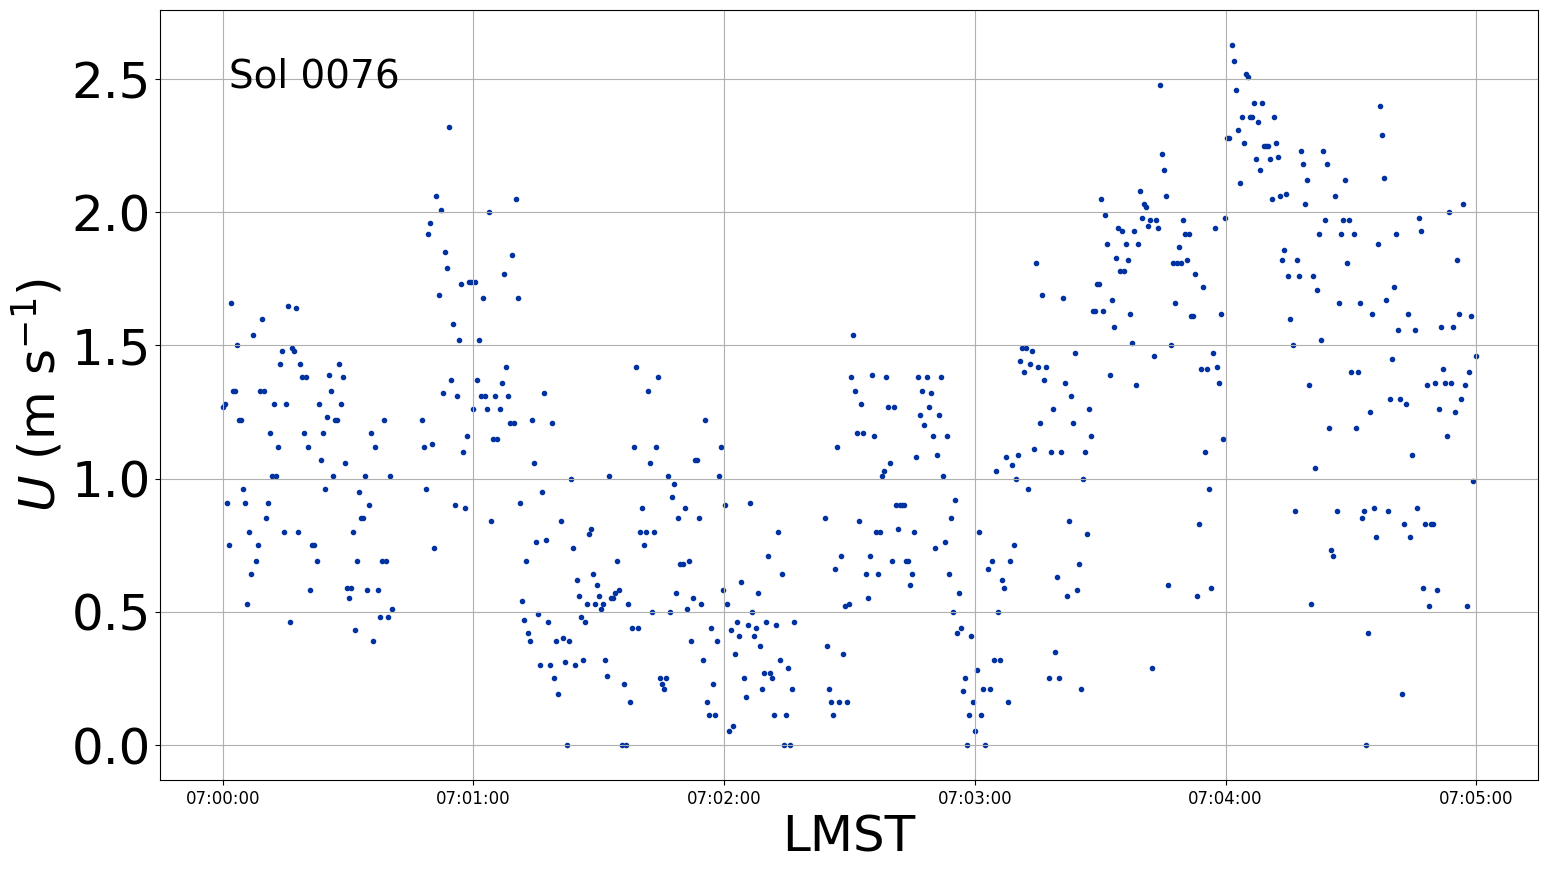

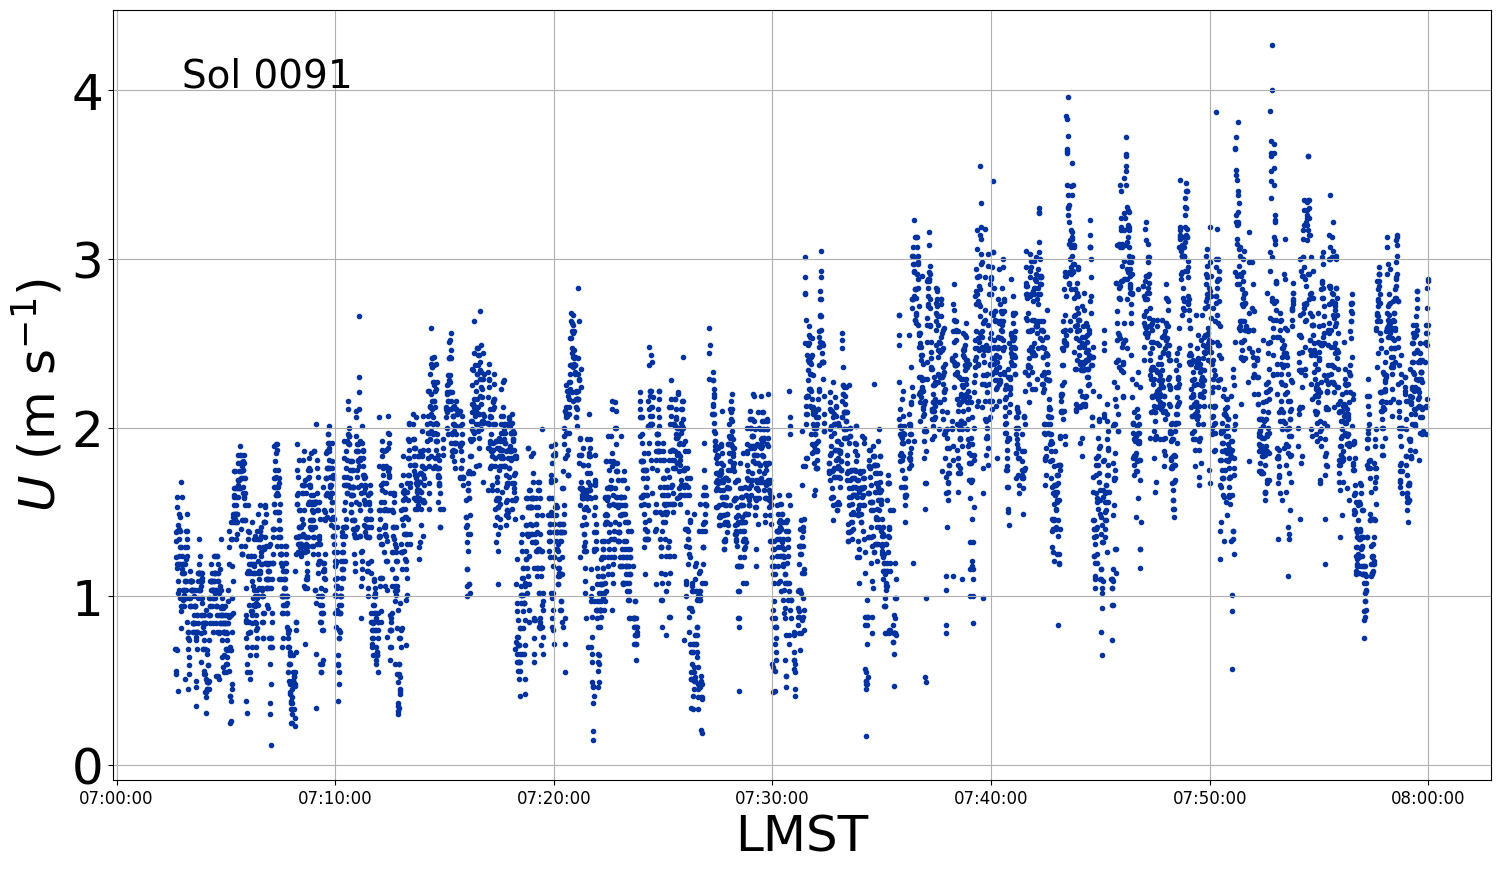

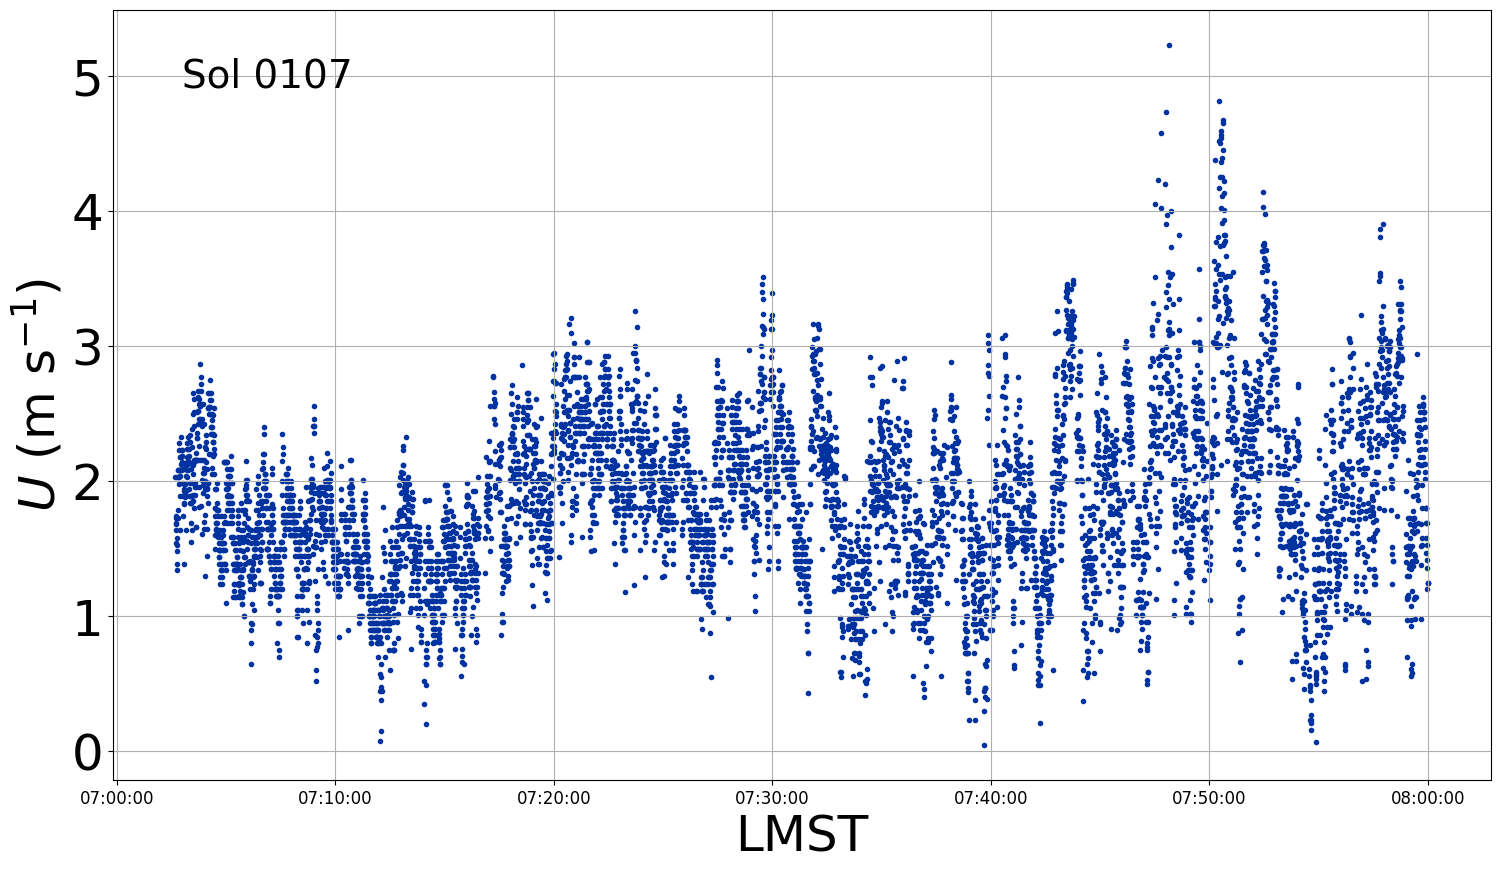

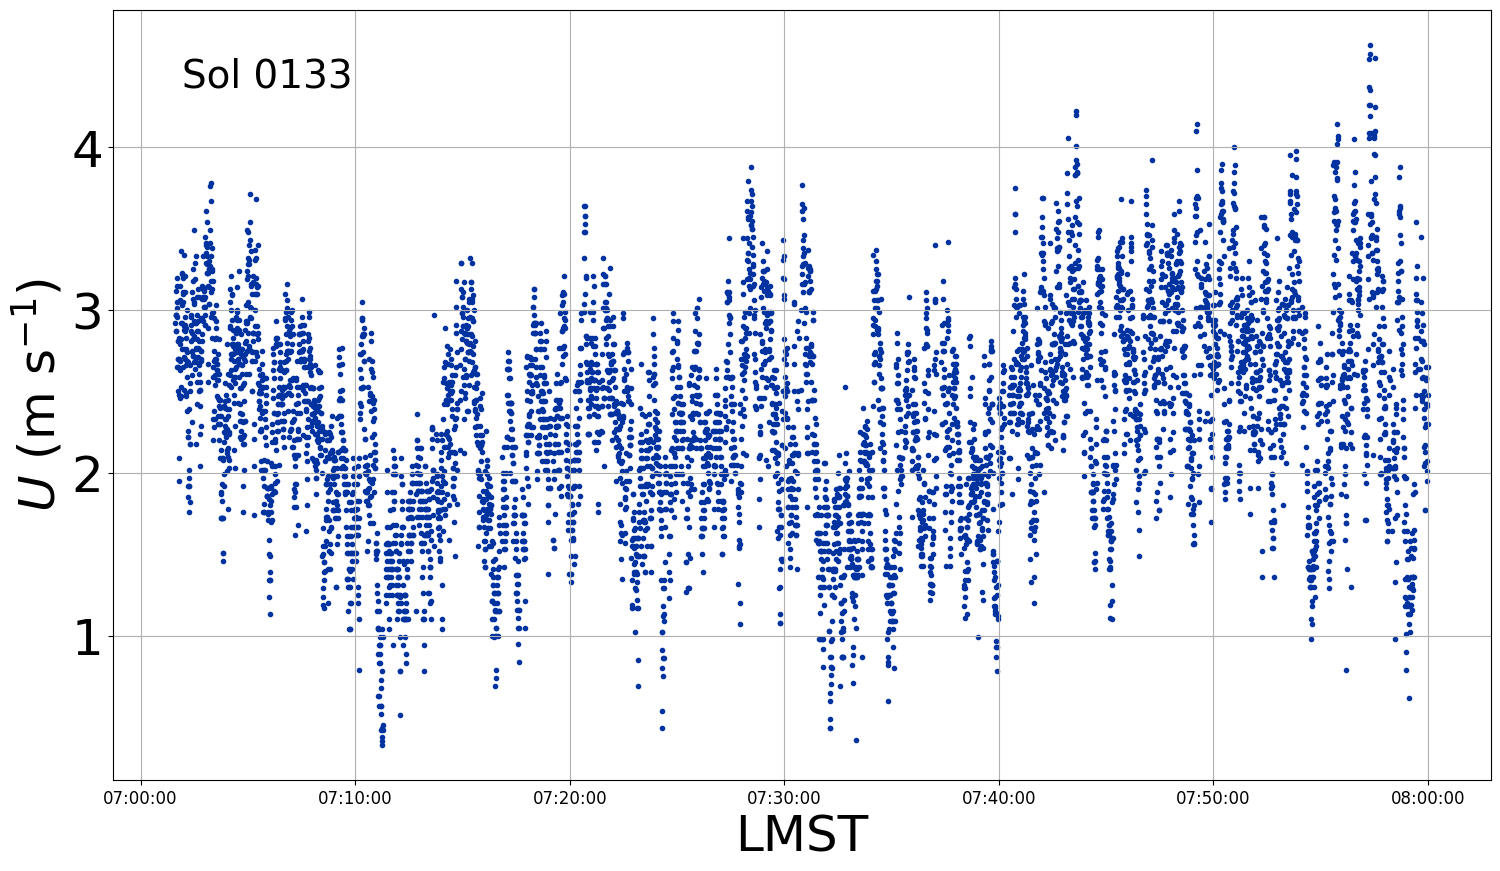

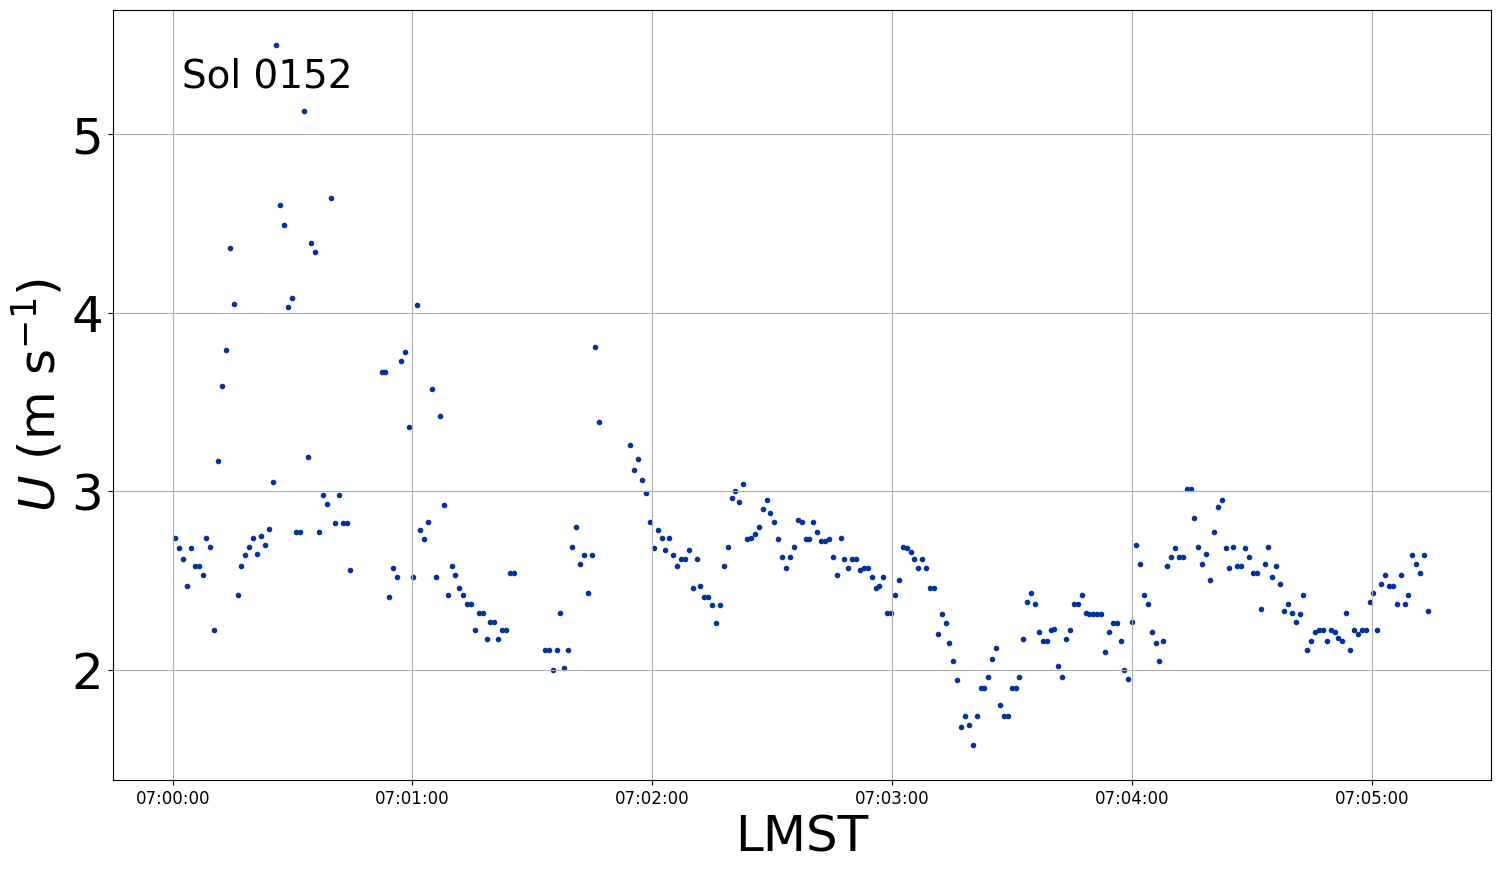

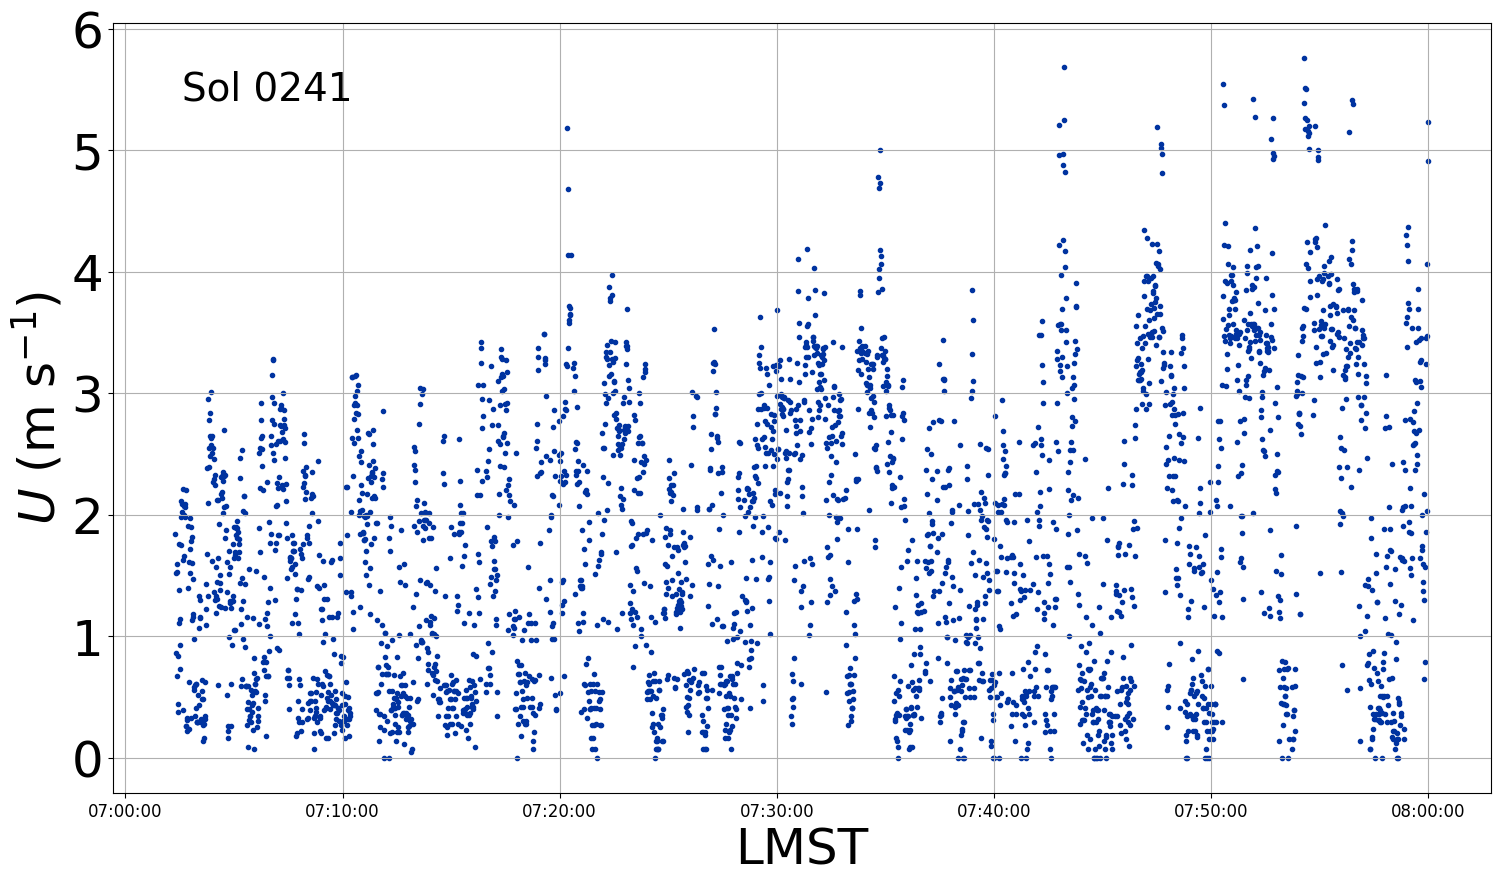

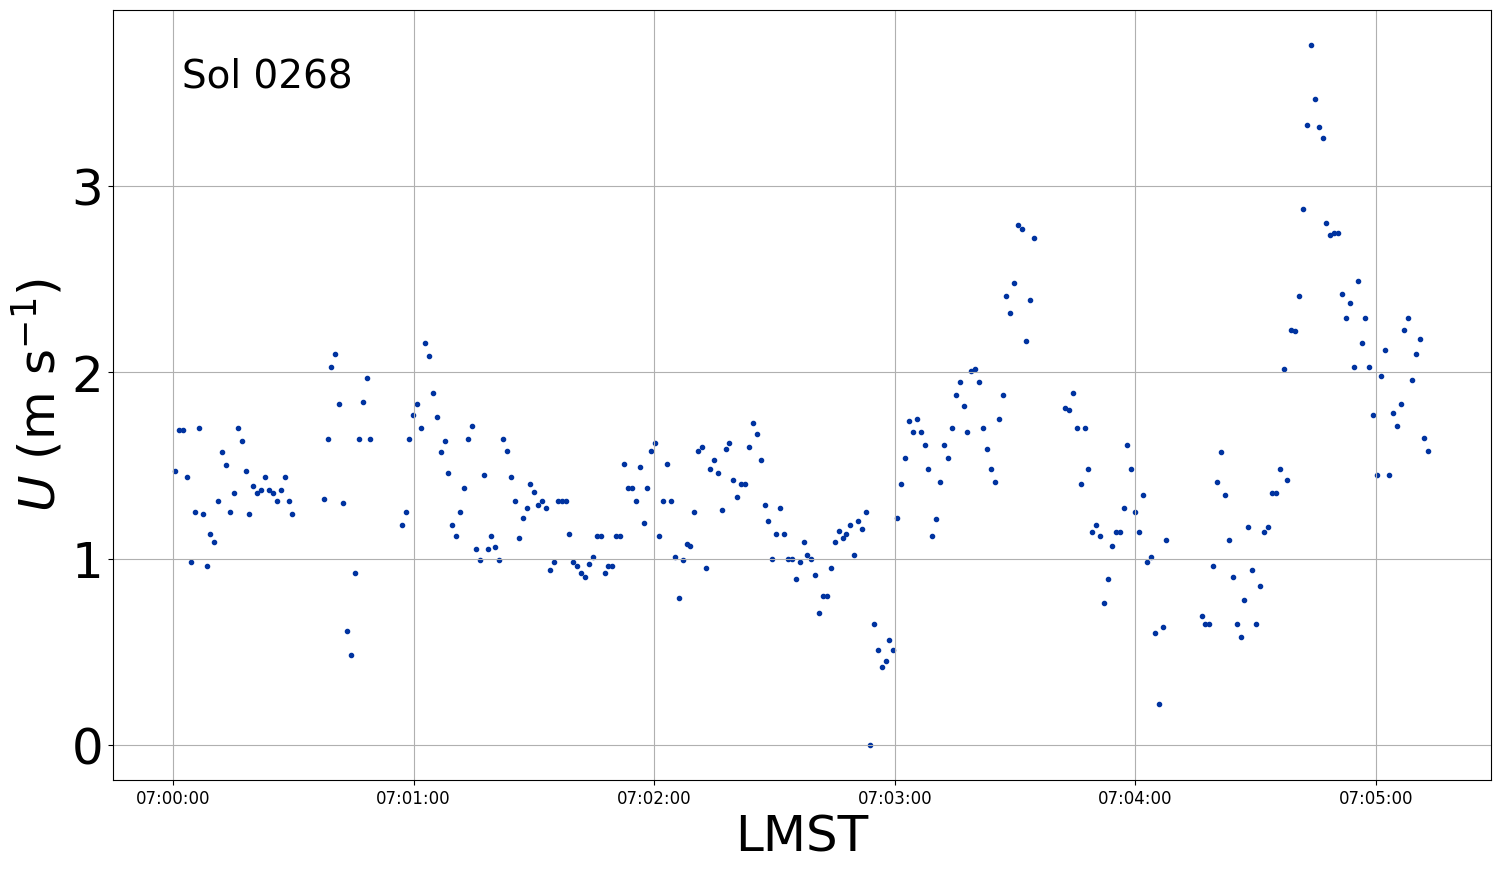

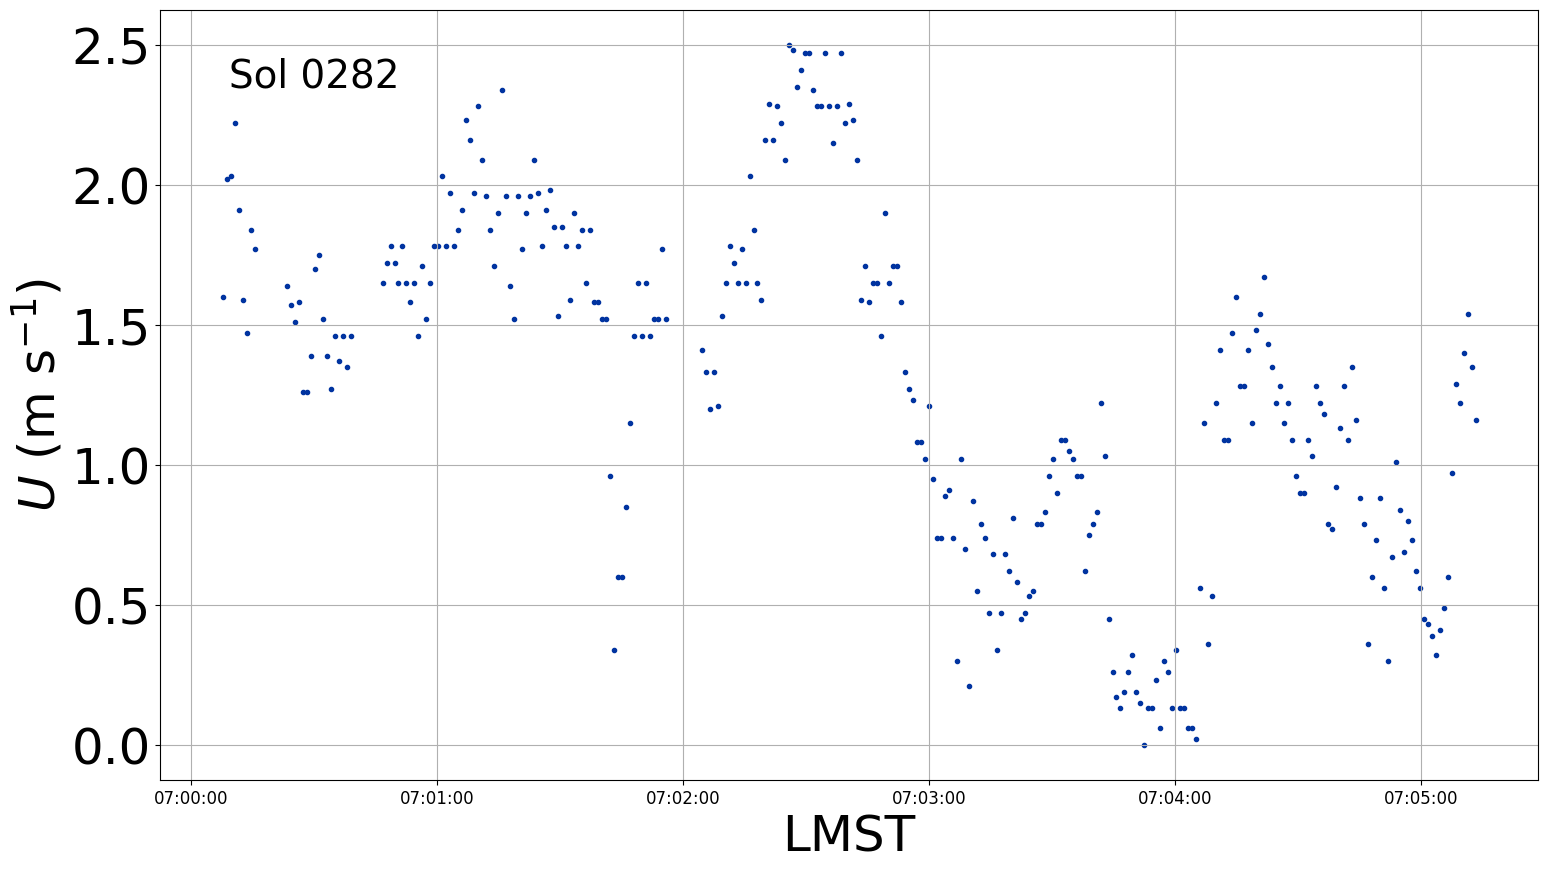

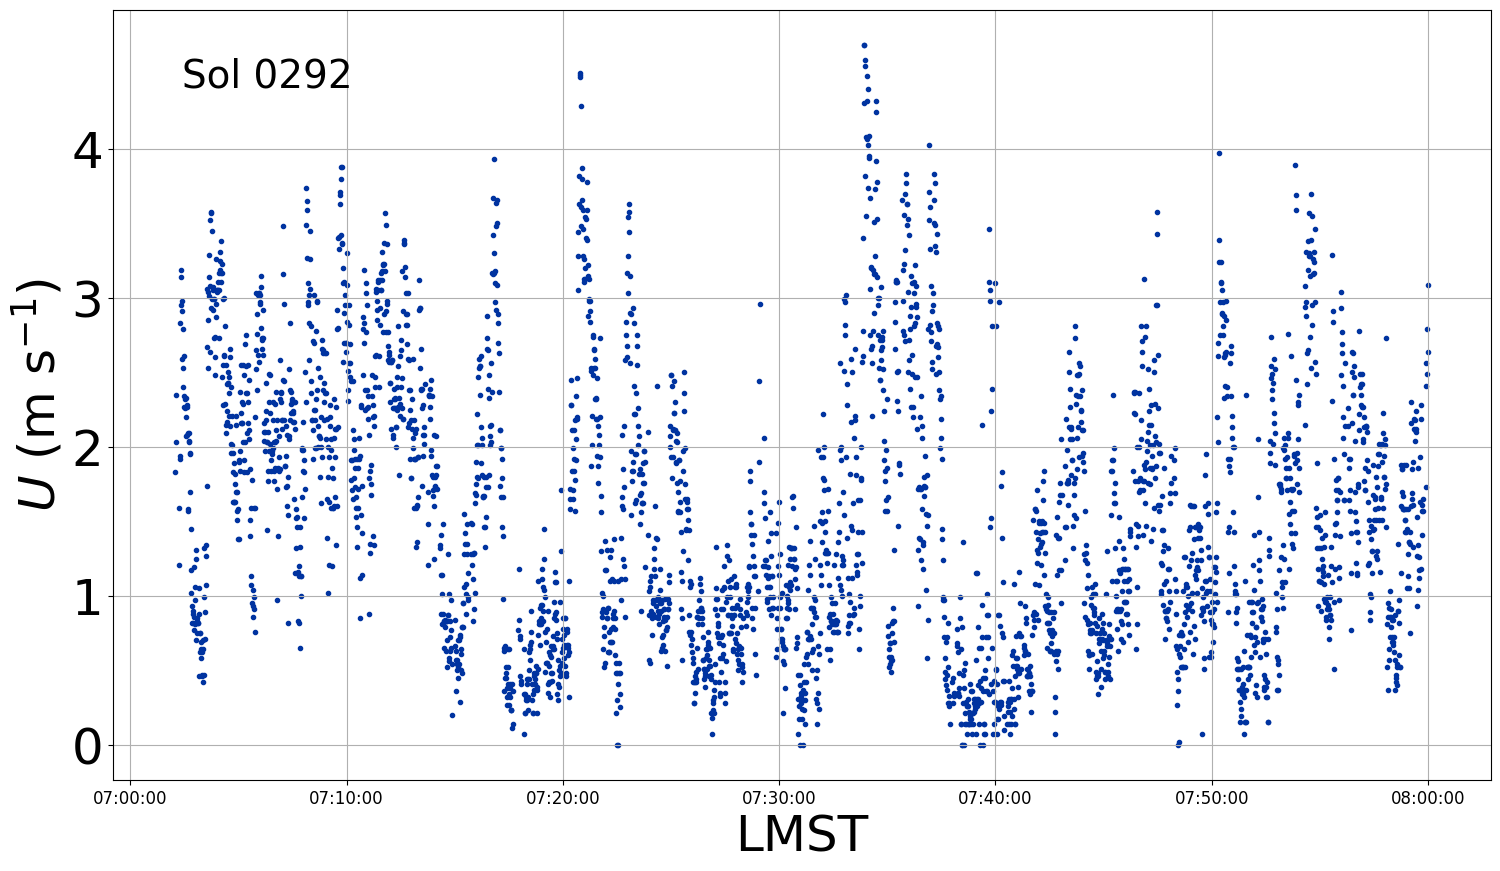

In [4]:
# Show baseline data for all files
for file_name in file_list:

    WS_file = path + file_name
    sol = WS_file.split('__')[1]

    fig = plt.figure(figsize=(10*aspect_ratio, 10))
    ax = fig.add_subplot(111)

    time, wind = retrieve_time_wind(WS_file)
    ax.scatter(time, wind, marker='.', color=BoiseState_blue)
    ax.text(0.05, 0.9, "Sol %s" % (sol), fontsize=28, transform=ax.transAxes)

    xfmt = md.DateFormatter('%H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    ax.grid(True)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=36)
    ax.set_xlabel("LMST", fontsize=36)
    ax.set_ylabel(r'$U\ \left( {\rm m\ s^{-1}} \right)$', fontsize=36)
    
    savefig_name = WS_file.replace(".xml", "_%s_%s.png" %\
                                   (np.min(time).strftime("%H-%M-%S"), np.max(time).strftime("%H-%M-%S")))
    fig.savefig(savefig_name, dpi=300, bbox_inches="tight")

0076
Processing label: /Users/brian/Documents/research/Active Projects/Measuring_Wind_with_Ingenuity/code/MEDA_WS_Data/WE__0076___________DER_WS__________________P02.xml
Now processing a Header structure: HEADER
Now processing a Table_Delimited structure: TABLE
0091
Processing label: /Users/brian/Documents/research/Active Projects/Measuring_Wind_with_Ingenuity/code/MEDA_WS_Data/WE__0091___________DER_WS__________________P02.xml
Now processing a Header structure: HEADER
Now processing a Table_Delimited structure: TABLE
0107
Processing label: /Users/brian/Documents/research/Active Projects/Measuring_Wind_with_Ingenuity/code/MEDA_WS_Data/WE__0107___________DER_WS__________________P02.xml
Now processing a Header structure: HEADER
Now processing a Table_Delimited structure: TABLE
0133
Processing label: /Users/brian/Documents/research/Active Projects/Measuring_Wind_with_Ingenuity/code/MEDA_WS_Data/WE__0133___________DER_WS__________________P02.xml
Now processing a Header structure: HEADER
No

Text(0, 0.5, '$z_\\star\\,\\left( {\\rm cm} \\right)$')

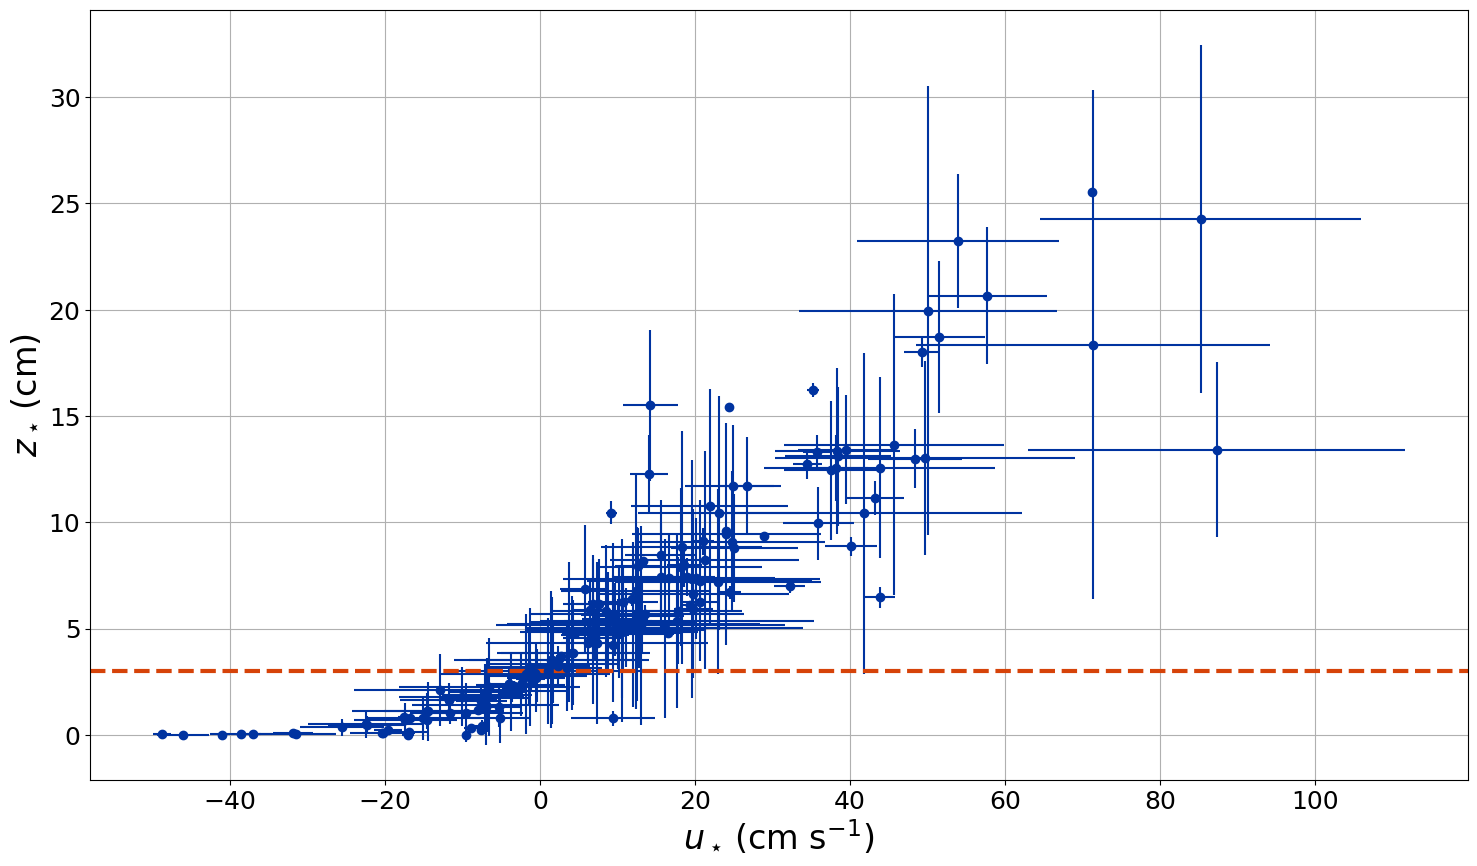

In [105]:
correct_ustars = np.array([])
saved_ustars = np.array([])
saved_zstars = np.array([])
saved_sigma_ustars = np.array([])
saved_sigma_zstars = np.array([])

for WS_file in file_list:
    sol = WS_file.split('__')[1]
    print(sol)

    time, wind = retrieve_time_wind(path + WS_file)
    # Convert to cm/s
    wind *= 100.
    
    # Create synthetic wind profile, converting wind speeds to cm/s
    scaled_windspeeds = create_synthetic_wind_profile(wind, zs, correct_zstar, z0=np.min(zs))

    # Cycle through the whole timeseries, sampling windows sample_time across
    t0 = np.min(time)
    while((t0 + sample_time) < np.max(time)):
        averaged_windspeeds, std_windspeeds = sample_wind_profile(sample_time, t0, time, scaled_windspeeds, zs)

        ### Fit synthetic wind profile ###
        inlier_zs, inlier_averaged_windspeeds, inlier_std_windspeeds,\
            outlier_zs, outlier_averaged_windspeeds, outlier_std_windspeeds,\
            popt, unc, pcov = fit_wind_profile_and_drop_outliers(zs, averaged_windspeeds, std_windspeeds,
                                                                 drop_outliers=True, num_sigma=5., 
                                                                 rescale_unc=True)
        
        # Collect ustar and zstar and uncertainties - Check that the fit worked
        if(popt is not None):
            correct_ustars = np.append(correct_ustars, kappa*averaged_windspeeds[0]/np.log(zs[0]/correct_zstar))
            ustar, zstar, sigma_ustar, sigma_zstar = collect_fit_values_and_unc(popt, unc, pcov)
        
            saved_ustars = np.append(saved_ustars, ustar)
            saved_zstars = np.append(saved_zstars, zstar)
            saved_sigma_ustars = np.append(saved_sigma_ustars, sigma_ustar)
            saved_sigma_zstars = np.append(saved_sigma_zstars, sigma_zstar)

        # Advance as far long as the previous sampling length over all windows
        t0 += sample_time*len(zs)
        
# plt.plot(saved_zstars, ls='', marker='.')
# plt.errorbar(np.arange(len(saved_zstars)), saved_zstars, yerr=saved_sigma_zstars, ls='', marker='.')
# plt.scatter(saved_zstars, saved_sigma_zstars, ls='', marker='.')

fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax = fig.add_subplot(111)

print(len(correct_ustars),len(saved_ustars))

ind = saved_ustars/saved_sigma_ustars > 3
ax.errorbar(saved_ustars[ind] - correct_ustars[ind], saved_zstars[ind], 
            xerr=saved_sigma_ustars[ind], yerr=saved_sigma_zstars[ind], 
            ls='', marker='o', color=BoiseState_blue)
ax.axhline(correct_zstar, ls='--', lw=3, color=BoiseState_orange)

ax.grid(True)
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$u_\star\,\left( {\rm cm\ s^{-1}} \right)$', fontsize=24)
ax.set_ylabel(r'$z_\star\,\left( {\rm cm} \right)$', fontsize=24)

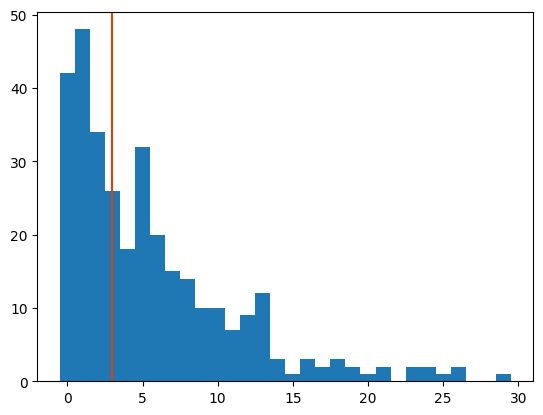

In [110]:
n, bins, patches = plt.hist(saved_zstars, bins=np.arange(-0.5, 30.5));
plt.axvline(correct_zstar, color=BoiseState_orange)

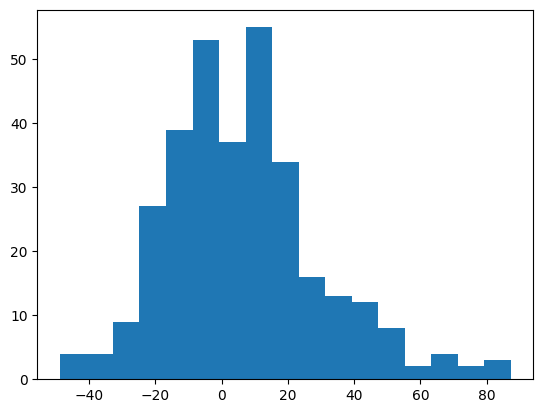

In [111]:
n, bins, patches = plt.hist(saved_ustars - correct_ustars, bins='auto');